# Stable Diffusion from Begginer to Master (3) VAE Deep Dive

- date: "2022-12-16"
- toc: true 
- badges: true
- comments: true
- categories: [Deep Learning, Python]
- hide: false

Starting from this 3rd tutorial of Stable Diffusion, we'll dive into the details of pipelines and see how each component work.

In this tutorial we'll breifly have a look at what components are there in a Pipeline, then take a deeper dive into one of the component - the Variationanl Auto Encoder(VAE).

# Setup

In [ ]:
!pip install -Uqq diffusers transformers ftfy accelerate bitsandbytes
#!pip install -Uqq triton xformers

# The Building Blocks of Stable Diffusion Pipeline

In [1]:
import torch
from diffusers import StableDiffusionPipeline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base', revision="fp16", torch_dtype=torch.float16).to(device)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Let's take a look at what is inside a `StableDiffusionPipeline`:

In [2]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.11.0.dev0",
  "feature_extractor": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

There are 5 main components of a `StableDiffusionPipeline`:

- `VAE` This is a downsampler + upsampler combination which works in the beginning and the end of the pipeline. It can "compress" the image from 512x512 -> 64x64 (8 times, which means the image sizes need to be divisible by 8) or "decompress" it back. 
- `Text Encoder` and `Tokenizer`  This two components work together to convert text prompts into embeddings.
- `UNet` This is the main module for diffusion, which takes a nosiy image and a text embedding as the input, and predicts the noise.
- `Scheduler` This determines the details of the diffusion process, e.g. how many steps to run, how much noise to remove at each step, etc.

# Encode and Decode with VAE

The VAE is a `encoder-decoder` combo, which can downsample an image to a smaller image(called `latents`) and then convert it back.

Why is this important? An image with `512x512` is worth `786432` numbers, combining that with convolutions(matrix multiplications) can use a lot of GPU memory and power. By downsampling it into a much smaller image, doing image generation on that, and then upsampling it to a large image can save a lot of memory and computing power. Although not necessary at all from a mathematical standpoint, the VAE is actually the key part that makes it possible to run stable diffusion on low-end GPUs, even personal computers.

In [3]:
import math
import PIL
import torch
import numpy as np
from matplotlib import pyplot as plt


def preprocess(image):
  w, h = image.size
  w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
  # PIL version compatiblity
  try:
    resample = PIL.Image.Resampling.LANCZOS
  except:
    resample = PIL.Image.LANCZOS
  image = image.resize((w, h), resample=resample)
  image = np.array(image).astype(np.float32) / 255.0
  image = image[None].transpose(0, 3, 1, 2)
  image = torch.from_numpy(image)
  return 2.0 * image - 1.0


def numpy_to_pil(images):
  """
  Convert a numpy image or a batch of images to a PIL image.
  """
  if images.ndim == 3:
      images = images[None, ...]
  images = (images * 255).round().astype("uint8")
  if images.shape[-1] == 1:
      # special case for grayscale (single channel) images
      pil_images = [PIL.Image.fromarray(image.squeeze(), mode="L") for image in images]
  else:
      pil_images = [PIL.Image.fromarray(image) for image in images]

  return pil_images


@torch.no_grad()
def encode_image(pipe, image, dtype=torch.float16):
  if isinstance(image, PIL.Image.Image):
    image = preprocess(image)
  image = image.to(device=device, dtype=dtype)
  latent_dist = pipe.vae.encode(image).latent_dist
  latents = latent_dist.sample(generator=None)
  latents = 0.18215 * latents
  return latents


@torch.no_grad()
def decode_latents(pipe, latents):
  latents = 1 / 0.18215 * latents
  image = pipe.vae.decode(latents).sample
  image = (image / 2 + 0.5).clamp(0, 1)
  # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
  image = image.cpu().permute(0, 2, 3, 1).float().numpy()
  image = numpy_to_pil(image)
  if len(image) == 1:
    # single image
    return image[0]
  return image


def image_grid(imgs, rows=None, cols=None) -> PIL.Image.Image:
  n_images = len(imgs)
  if not rows and not cols:
    cols = math.ceil(math.sqrt(n_images))
  if not rows:
    rows = math.ceil(n_images / cols)
  if not cols:
    cols = math.ceil(n_images / rows)

  w, h = imgs[0].size
  grid = PIL.Image.new('RGB', size=(cols*w, rows*h))

  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

Now let's try out the VAE.
1. The original image is `(516, 484)`
2. `preprocess` will resize it to the nearest size divisible by 8, which is `(512, 480)`.
3. `encode_image` converts image to latents with 4 channels, each with `(60,64)`, which is 1/8 the original size. Note the x and y switches only because image size is `(width, height)` but array shape is `(height, width)`.
4. `decode_latents` converts latents back to image, which is `(512, 480)`.

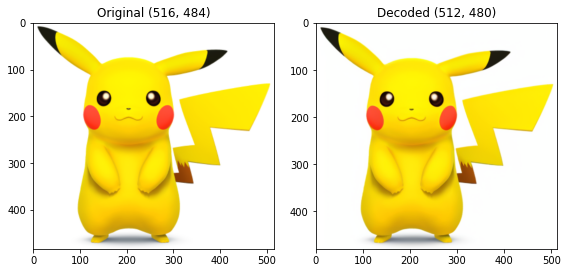

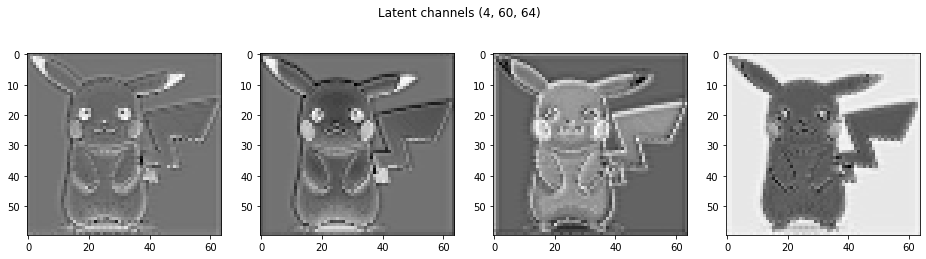

In [6]:
def demo_vae(image, latents, decoded_image):
  fig, axes = plt.subplots(figsize=(8,4), nrows=1, ncols=2)
  plt.tight_layout()
  axes[0].imshow(image)
  # axes[0].set_axis_off()
  axes[0].set_title(f'Original {image.size}')
  axes[1].imshow(decoded_image)
  # axes[1].set_axis_off()
  axes[1].set_title(f'Decoded {decoded_image.size}')

  if len(latents.shape) == 4:
    latents = latents[0]
  latents = latents.float().cpu().numpy()
  n_channels = latents.shape[0]

  fig, axs = plt.subplots(1, n_channels, figsize=(n_channels*4, 4))
  fig.suptitle(f'Latent channels {latents.shape}') 

  for c in range(n_channels):
    axs[c].imshow(latents[c], cmap='Greys')

image = PIL.Image.open('images/pikachu.png').convert('RGB')
latents = encode_image(pipe, image)
decoded_image = decode_latents(pipe, latents)

demo_vae(image, latents, decoded_image)

# Fun experiment: adding some random noise to latents

What if we add some random noise to the latents? Will VAE still be able to restore the original image?

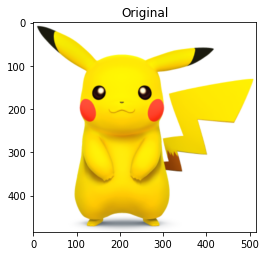

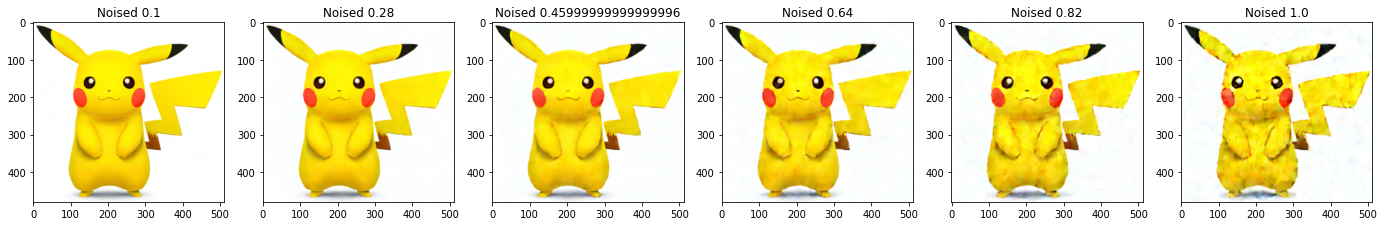

In [149]:
def add_rand_noise(latents, noise_level):
  scale = torch.mean(torch.abs(latents))
  return latents + (torch.rand_like(latents)-0.5) * scale * noise_level

image = PIL.Image.open('images/pikachu.png').convert('RGB')
latents = encode_image(pipe, image)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.imshow(image)
axs.set_title('Original')
# axs.set_axis_off()

count = 6
noise_levels = np.linspace(0.1,1,count)
fig, axs = plt.subplots(1, count, figsize=(4*count, 4))
for ax, noise in zip(axs, noise_levels): 
  latents1 = add_rand_noise(latents, noise)
  decoded_image = decode_latents(pipe, latents1)
  ax.imshow(decoded_image)
  ax.set_title(f'Noised {noise}')
  # ax.set_axis_off()


As you can see in the above, VAE is quite resilient to noises. Even when adding roughly 50% noise with respect to the mean latent value scale(!!!), it can still do quite a good job of restoring the image.

# Playing with VAE code

Now we'll dive into the VAE code to see what is going on. To do this in colab, we can add some print statements to [diffusers/model/vae.py](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/vae.py)

To relect our changes without having to restart the colab runtime, we can run the following reload code:

In [7]:
from diffusers.models import vae
import importlib
importlib.reload(vae)
pipe.vae.__class__ = vae.AutoencoderKL

The `encode` function encodes an image of shape `[1,3,h,w]` into a latent tensor `[1,4,h/8,w/8]`.

```python
def encode(self, x: torch.FloatTensor, return_dict: bool = True) -> AutoencoderKLOutput:
    # x: [1, 3, h, w]

    # h: [1, 8, h/8, w/8]
    h = self.encoder(x)
    
    # moments: [1, 8, h/8, w/8]
    moments = self.quant_conv(h)
    
    # posterior.std: [1, 4, h/8, w/8]
    # posterior.var: [1, 4, h/8, w/8]
    posterior = DiagonalGaussianDistribution(moments)

    if not return_dict:
        return (posterior,)

    return AutoencoderKLOutput(latent_dist=posterior)
```

- The `encoder` is a `UNet` that converts from input image `x` with shape `[1,3,h,w]` into a tensor `h` with shape `[1,8,h/8,w/8]`.
- `quant_conv` is a `Conv2d` block with kernel size 1, which converts `h` into `moments` preserving the shape.
- The `moments` with shape `[1,8,h/8,w/8]` is used as the standard deviation and variance of a distribution, from which the latents are sampled.

In [29]:
from diffusers.models.vae import DiagonalGaussianDistribution

image = PIL.Image.open('images/pikachu.png').convert('RGB')
print('image:', image.size)
x = preprocess(image).to(device=device, dtype=torch.float16)
print('image tensor:', x.shape)
h = pipe.vae.encoder(x)
print('h:', h.shape)
moments = pipe.vae.quant_conv(h)
print('moments:', moments.shape)
latent_dist = DiagonalGaussianDistribution(moments)
latents = latent_dist.sample(generator=None)
latents = 0.18215 * latents
print('latents:', latents.shape)

image: (516, 484)
image tensor: torch.Size([1, 3, 480, 512])
h: torch.Size([1, 8, 60, 64])
moments: torch.Size([1, 8, 60, 64])
latents: torch.Size([1, 4, 60, 64])


Now the `decode` function:

```python
def _decode(self, z: torch.FloatTensor, return_dict: bool = True) -> Union[DecoderOutput, torch.FloatTensor]:
    z = self.post_quant_conv(z)
    dec = self.decoder(z)

    if not return_dict:
        return (dec,)

    return DecoderOutput(sample=dec)

def decode(self, z: torch.FloatTensor, return_dict: bool = True) -> Union[DecoderOutput, torch.FloatTensor]:
    if self.use_slicing and z.shape[0] > 1:
        decoded_slices = [self._decode(z_slice).sample for z_slice in z.split(1)]
        decoded = torch.cat(decoded_slices)
    else:
        decoded = self._decode(z).sample

    if not return_dict:
        return (decoded,)

    return DecoderOutput(sample=decoded)
```

- `post_quant_conv` is a `Conv2d` with input channel and output channel equal to the latent channels (=4), kernel size 1. It converts `latents` to `z` with the same shape.
- `decoder` is a `UNet` that converts from latent shape `[1,4,h/8,w/8]` into an image tensor of shape `[1,3,h,w]`.

latents: torch.Size([1, 4, 60, 64])
z: torch.Size([1, 4, 60, 64])
dec: torch.Size([1, 3, 480, 512])


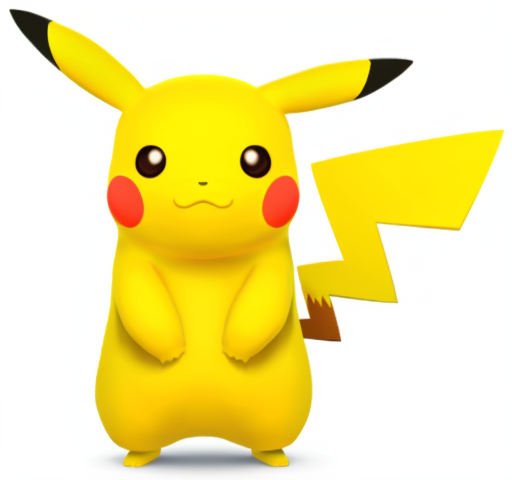

In [30]:
latents = 1 / 0.18215 * latents
print('latents:', latents.shape)
z = pipe.vae.post_quant_conv(latents)
print('z:', z.shape)
dec = pipe.vae.decoder(z)
print('dec:', dec.shape)
image = (dec.detach() / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).float().numpy()
image = numpy_to_pil(image)[0]
display(image)

We won't dive deeper into the Encoder and Decoder (both are `UNet`, which is a special kind of Convolutional network, characterized by first scaling down and then scaling up feature maps). But you can defintely have a look at the source code to dig more details.

In [31]:
pipe.vae.encoder

Encoder(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): DownEncoderBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): Si